# Imports and helper functions

In [1]:
import torch
import matplotlib.pylab as plt
from env import VanillaEnv
from typing import List
from torchvision.utils import make_grid
from rl.common.buffer2 import Transition, Episode
import numpy as np
import time

In [2]:
def compare_imgs(a,b,title:str = ""):
   f, axarr = plt.subplots(1,2)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()

In [3]:
def generate_expert_trajectories(env, n_episodes):
    gamma = 0.99

    episodes: List[Episode] = []

    for i in range(n_episodes):
        done = False
        episode = Episode(discount=gamma)
        obs = env.reset()
        obstacle_position = env.actualEnv.obstacle_position
        jumping_pixel = obstacle_position - 14
        step = 0
        while not done:
            action = 1 if step == jumping_pixel else 0
            next_obs, reward, done, _ = env.step(action)
            episode.append(Transition(obs, action, reward, 0))
            obs = next_obs
            env.render()
            step += 1

        episodes.append(episode)
    return episodes

X = generate_expert_trajectories(VanillaEnv(configurations=[(38, 8)]), n_episodes=1)[0]
Y = generate_expert_trajectories(VanillaEnv(configurations=[(22, 32)]), n_episodes=1)[0]
X_action = X.actions()
Y_action = Y.actions()

# Manual calculation of PSE

First MPD:
| $x_n \sim \mathcal{X}$ | $x_1$  | $x_2$  | $x_3$|$x_4$|$x_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{X}^*(x)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{X}^*(x))$ |0|0|0|1|0|

Second MPD:
| $y_n \sim \mathcal{Y}$|$y_1$|$y_2$|$y_3$|$y_4$|$y_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{Y}^*(y)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{Y}^*(y))$ |0|1|0|0|0|

$
\begin{align}
d^*(x,y) &= TV(\pi_\mathcal{X}^*(\cdot |x), \pi_\mathcal{Y}^*(\cdot |y)) + \gamma W_1(d^*)\left( P_\mathcal{X}^{\pi^*}(\cdot|x),P_\mathcal{Y}^{\pi^*}(\cdot|y) \right) 
\\
d^*(x_i,y_j) &= TV(\arg \max(\pi_\mathcal{X}^*(x_i)),\arg \max(\pi_\mathcal{Y}^*(y_j))) + \gamma d^*(x_{i+1}, y_{j+1})
\\
d^*(x_i,y_j) &= TV(a_{\mathcal{X}, i}^*,a_{\mathcal{Y}, i}^*) + \gamma d^*(x_{i+1}, y_{j+1})
\\[.4cm]
\text{for two specific states (see table above):}
\\
d^*(x_2,y_2) &= TV(0,1) + \gamma \cdot d^*(x_3,y_3) \\
&= TV(0,1) + \gamma \cdot TV(0,0) + \gamma^2  \cdot TV(1,0) + \gamma^3 \cdot TV(0,0) \\
&= 1 + \gamma^2 = 1.9801
\end{align}
$

|$d(x_1, y_1)$|$d(x_1, y_2)$|$d(x_1, y_3)$|$d(x_1, y_4)$|$d(x_1, y_5)$|
|:-:|:-:|:-:|:-:|:-:|
|$d(x_2, y_1)$|$d(x_2, y_2)$|$d(x_2, y_3)$|$d(x_2, y_4)$|$d(x_2, y_5)$|
|$d(x_3, y_1)$|$d(x_3, y_2)$|$d(x_3, y_3)$|$d(x_3, y_4)$|$d(x_3, y_5)$|
|$d(x_4, y_1)$|$d(x_4, y_2)$|$d(x_4, y_3)$|$d(x_4, y_4)$|$d(x_4, y_5)$|
|$d(x_5, y_1)$|$d(x_5, y_2)$|$d(x_5, y_3)$|$d(x_5, y_4)$|$d(x_5, y_5)$|

$d(x_5, y_5) = TV(a_{x5}, a_{y5}) = TV(0,0) = 0$ <br>
$d(x_4, y_4) = TV(a_{x4}, a_{y4}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) = 1$ <br>
$d(x_3, y_3) = TV(a_{x3}, a_{y3}) + \gamma \cdot TV(a_{x4}, a_{y4}) = TV(0,0) + \gamma \cdot 1 = 0.99$ <br>
$d(x_2, y_2) = TV(a_{x2}, a_{y2}) + \gamma \cdot TV(a_{x3}, a_{y3}) = TV(0,1) + \gamma \cdot 0.99 = 1.9801$ <br>
$d(x_1, y_1) = TV(a_{x1}, a_{y1}) + \gamma \cdot TV(a_{x2}, a_{y2}) = TV(0,0) + \gamma \cdot 1.9801 = 1.960299$ <br>

Is the following really correct? If there is no state $y_{i+1}$ then we just take $y_{i}$? Where is this indicated in the formulars? 

$d(x_4, y_5) = TV(a_{x4}, a_{y5}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) + \gamma \cdot 0 = 1$<br>
$d(x_3, y_5) = TV(a_{x3}, a_{y5}) + \gamma \cdot TV(a_{x4}, a_{y5}) = TV(0,0) + \gamma \cdot 1 = 0.99$<br>
$d(x_2, y_5) = TV(a_{x2}, a_{y5}) + \gamma \cdot TV(a_{x3}, a_{y5}) = TV(0,0) + \gamma \cdot 0.99 = 0.9801$<br>
$d(x_1, y_5) = TV(a_{x1}, a_{y5}) + \gamma \cdot TV(a_{x2}, a_{y5}) = TV(0,0) + \gamma \cdot 0.9801 = 0.970299$<br>

Without recursion: <br>
$\begin{align}
d(x_1, y_3) &= \gamma^0 TV(a_{x1}, a_{y3}) + \gamma^1 TV(a_{x2}, a_{y4}) + \gamma^2 TV(a_{x3}, a_{y5}) + \gamma^3 TV(a_{x4}, a_{y5}) + \gamma^4 TV(a_{x5}, a_{y5})\\
&= \gamma^0 TV(0,0) + \gamma^1 TV(0,0) + \gamma^2 TV(0,0) + \gamma^3 TV(1,0) + \gamma^4 TV(0,0)\\
&=  \gamma^3 = 0.970299
\end{align}$


# Code from the paper (converted to numpy)

In [4]:
def metric_fixed_point_fast(cost_matrix, gamma=0.99, eps=1e-7):
  """Dynamic prograaming for calculating PSM."""
  d = np.zeros_like(cost_matrix)
  def operator(d_cur):
    d_new = 1 * cost_matrix
    discounted_d_cur = gamma * d_cur
    d_new[:-1, :-1] += discounted_d_cur[1:, 1:]
    d_new[:-1, -1] += discounted_d_cur[1:, -1]
    d_new[-1, :-1] += discounted_d_cur[-1, 1:]
    return d_new

  while True:
    d_new = operator(d)
    if np.sum(np.abs(d - d_new)) < eps:
      break
    else:
      d = d_new[:]
  return d


def compute_metric(actions1, actions2, gamma):
  diff = np.expand_dims(actions1, axis=1) - np.expand_dims(actions2, axis=0)
  action_cost = np.mean(np.abs(diff), axis=-1).astype(np.float32)
  return metric_fixed_point_fast(np.array(action_cost), gamma=gamma)


print(compute_metric([[0],[0],[0],[1],[0]], [[0],[1],[0],[0],[0]], 0.99))
print(compute_metric([[0,0,0,1,0]], [[0,1,0,0,0]], 0.99))

[[1.960299   1.970299   0.97029907 0.97029907 0.97029907]
 [1.9701     1.9801     0.98010004 0.98010004 0.98010004]
 [0.         1.99       0.99       0.99       0.99      ]
 [1.99       0.         1.         1.         1.        ]
 [0.99       1.         0.         0.         0.        ]]
[[0.4]]


# PSE (different different versions)

In [5]:
# calculate PSM for specific states x and y
def psm_single(x_arr, y_arr, x_idx, y_idx, gamma=0.99):
    """
    Calculates the psm for the enire sequence (starting at the first element)
    """
    tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
    if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
        return tv
    else:
        return tv + gamma * psm_single(x_arr,y_arr, min(x_idx+1, len(x_arr)-1), min(y_idx+1, len(y_arr)-1), gamma)


for i in range(0,5):
    for j in range(0,5):
        print(f"{psm_single([0,0,0,1,0], [0,1,0,0,0], x_idx = i, y_idx=j):.6f}", end=', ')
    print("")

1.960299, 1.970299, 0.970299, 0.970299, 0.970299, 
1.970100, 1.980100, 0.980100, 0.980100, 0.980100, 
0.000000, 1.990000, 0.990000, 0.990000, 0.990000, 
1.990000, 0.000000, 1.000000, 1.000000, 1.000000, 
0.990000, 1.000000, 0.000000, 0.000000, 0.000000, 


In [6]:
# calculate psm for all states from X and Y 

def psm_total(x_arr, y_arr, gamma=0.99):
    storage = np.full(shape=(len(x_arr), len(y_arr)), fill_value=-1.0)
    
    def psm_dyn(x_idx, y_idx):
        tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
        if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
            return tv
        else:
            next_x_idx = min(x_idx+1, len(x_arr)-1)
            next_y_idx = min(y_idx+1, len(y_arr)-1)
            next_psm = psm_dyn(next_x_idx, next_y_idx) if storage[next_x_idx, next_y_idx] == -1 else storage[next_x_idx, next_y_idx]
            return tv + gamma * next_psm

    for i in range(len(x_arr)):
        for j in range(len(y_arr)):
            storage[i,j] = psm_dyn(i,j)
    return storage

print(psm_total([0,0,0,1,0], [0,1,0,0,0]))


[[1.960299 1.970299 0.970299 0.970299 0.970299]
 [1.9701   1.9801   0.9801   0.9801   0.9801  ]
 [0.       1.99     0.99     0.99     0.99    ]
 [1.99     0.       1.       1.       1.      ]
 [0.99     1.       0.       0.       0.      ]]


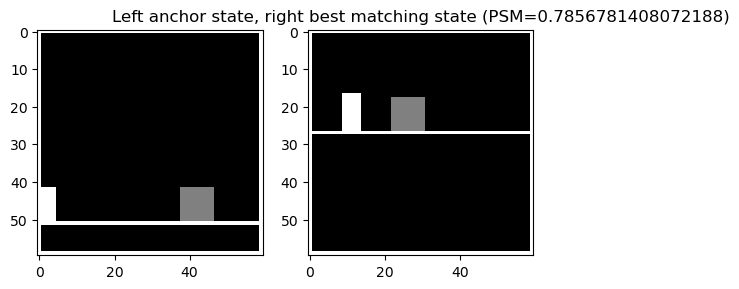

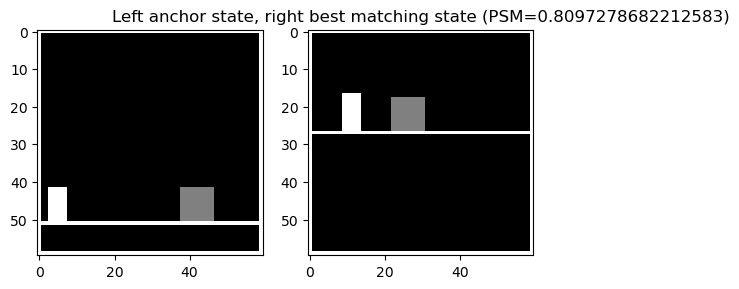

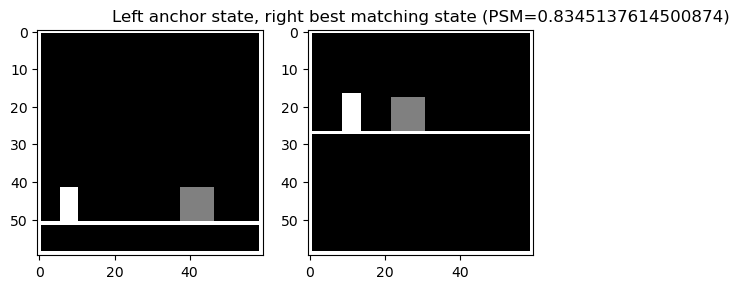

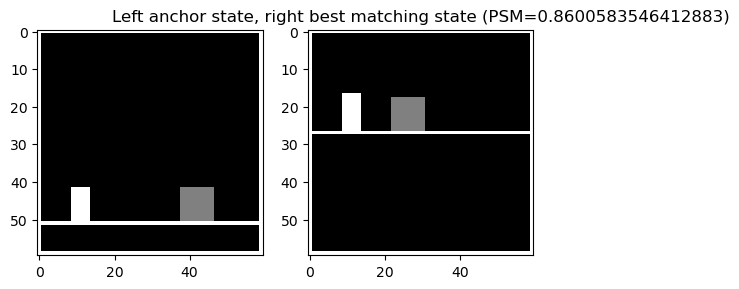

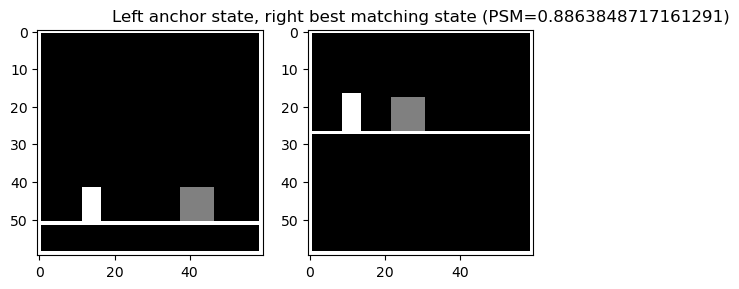

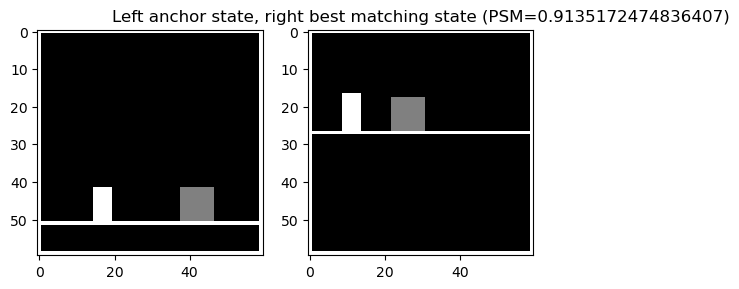

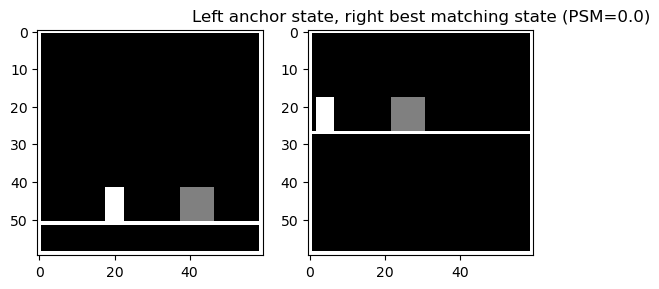

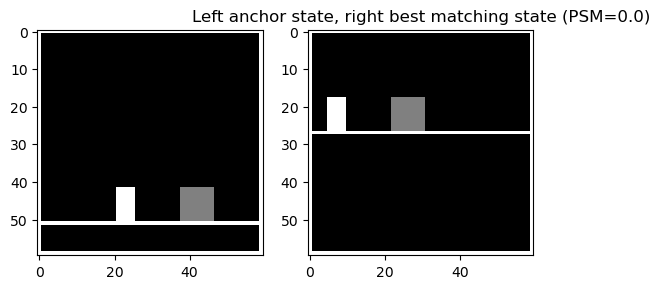

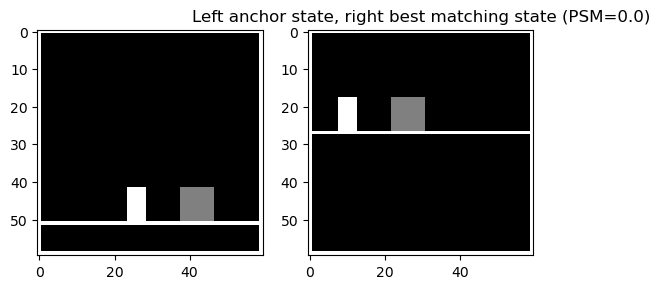

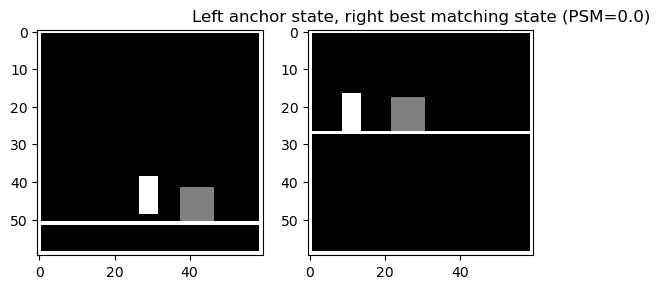

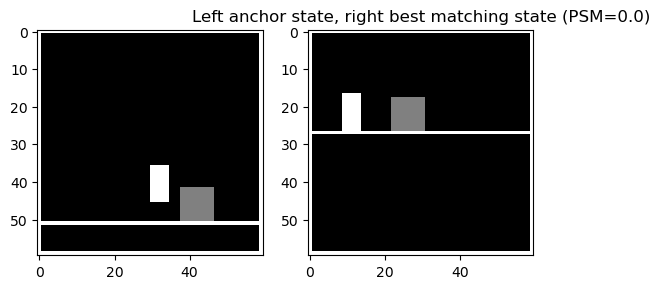

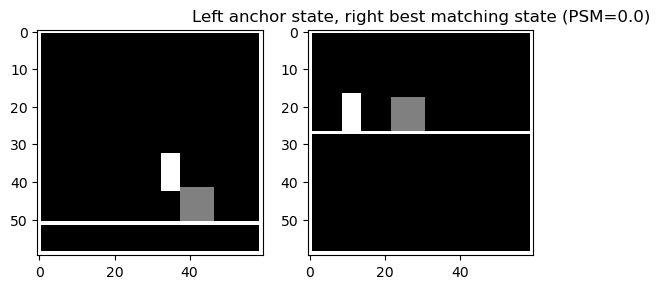

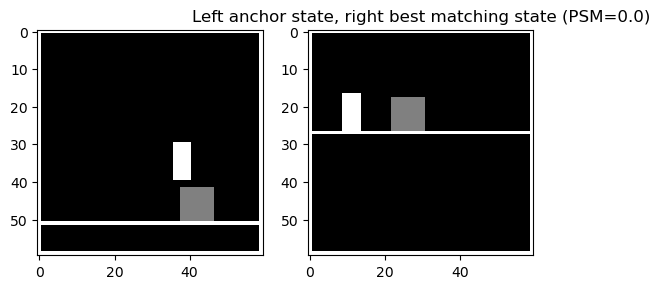

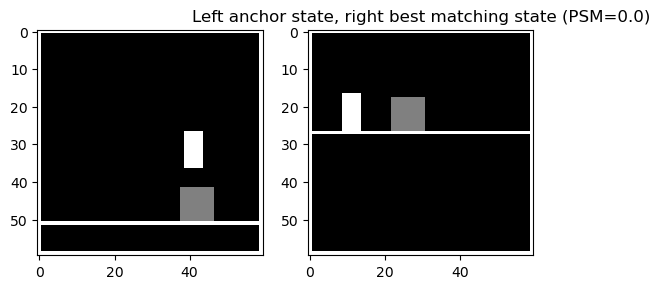

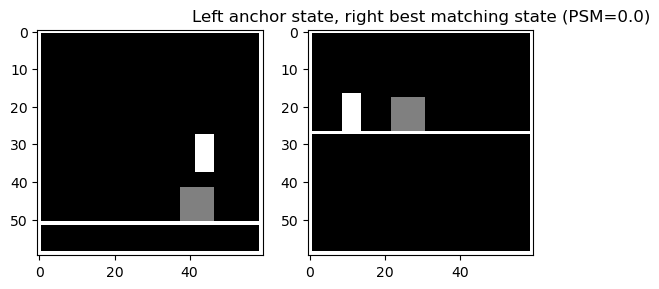

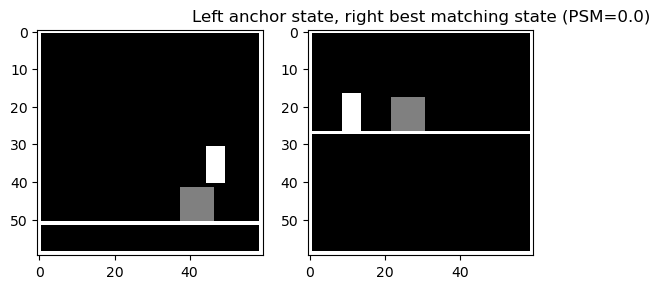

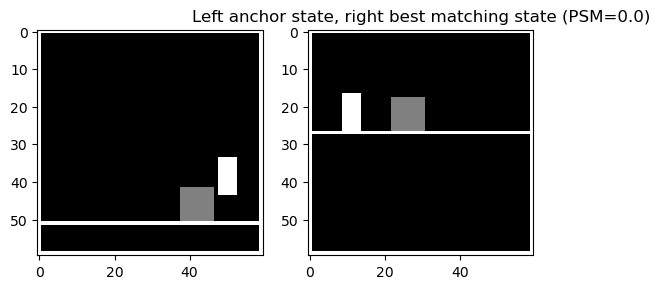

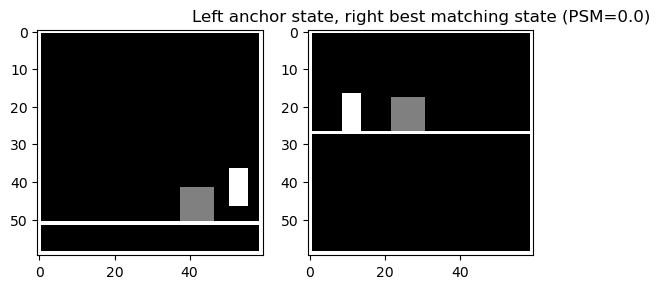

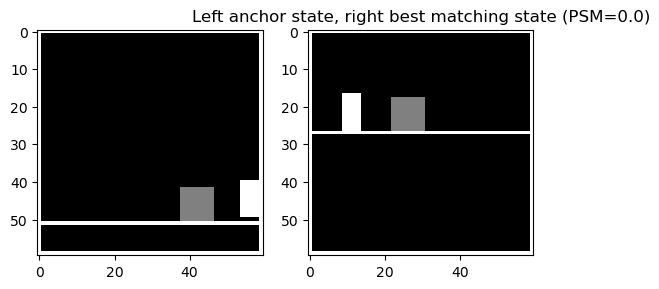

In [25]:
compare_idx = 20
psm = psm_total(X_action, Y_action)
psm2 = compute_metric(np.array(X_action, ndmin=2).T, np.array(Y_action, ndmin=2).T, 0.99)

assert np.allclose(psm, psm2) , "My method computes other PSM values than the one from the paper!"

for compare_idx in range(0, len(X_action)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    matching_idx = np.argmin(psm[compare_idx])
    if compare_idx % 3 == 0: compare_imgs(X.transitions[compare_idx].state, Y.transitions[matching_idx].state, f"Left anchor state, right best matching state (PSM={psm[compare_idx][matching_idx]})")


In [30]:
def psm2_tot(x_arr, y_arr, gamma_forward=0.99, gamma_backward=0.5):
    storage = np.full(shape=(len(x_arr), len(y_arr)), fill_value=-1.0)
    
    def psm2_dyn_forward(x_idx, y_idx):
        tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
        if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
            return tv
        else:
            next_x_idx = min(x_idx+1, len(x_arr)-1)
            next_y_idx = min(y_idx+1, len(y_arr)-1)

            next_psm = psm2_dyn_forward(next_x_idx, next_y_idx) if storage[next_x_idx, next_y_idx] == -1 else storage[next_x_idx, next_y_idx]
            return tv + gamma_forward * next_psm

    def psm2_dyn_backward(x_idx, y_idx):
        tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
        if x_idx == 0 and y_idx == 0:
            return tv
        else:
            past_x_idx = max(x_idx-1, 0)
            past_y_idx = max(y_idx-1, 0)

            past_psm = psm2_dyn_backward(past_x_idx, past_y_idx) if storage[past_x_idx, past_y_idx] == -1 else storage[past_x_idx, past_y_idx]
            return tv + gamma_backward * past_psm

    for i in range(len(x_arr)):
        for j in range(len(y_arr)):
            storage[i,j] = psm2_dyn_forward(i,j) + psm2_dyn_backward(i,j)
    return storage
print(psm_total([1,0,0,0,0], [0,1,0,0,0]))
print(psm2_tot([1,0,0,0,0], [0,1,0,0,0]))

[[1.99 0.   1.   1.   1.  ]
 [0.99 1.   0.   0.   0.  ]
 [0.99 1.   0.   0.   0.  ]
 [0.99 1.   0.   0.   0.  ]
 [0.99 1.   0.   0.   0.  ]]
[[2.99     1.495    2.7475   3.37375  3.686875]
 [2.485    3.495    0.7475   1.37375  1.686875]
 [2.2325   3.2425   1.7475   0.37375  0.686875]
 [2.10625  3.11625  1.62125  0.87375  0.186875]
 [2.043125 3.053125 1.558125 0.810625 0.436875]]


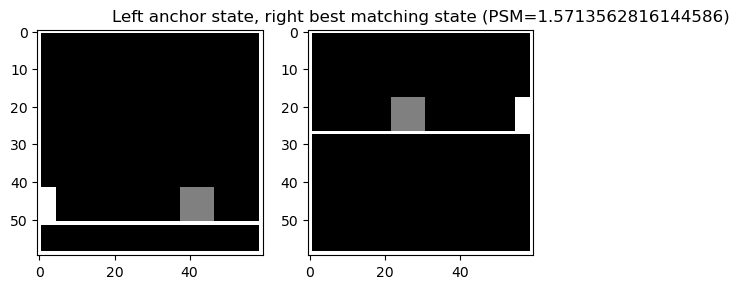

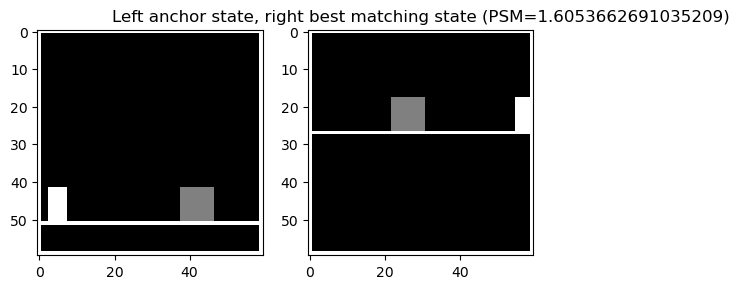

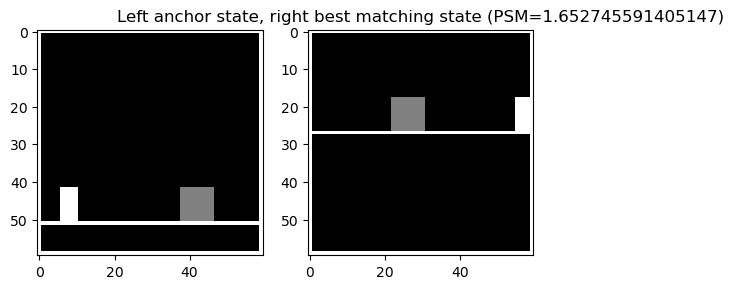

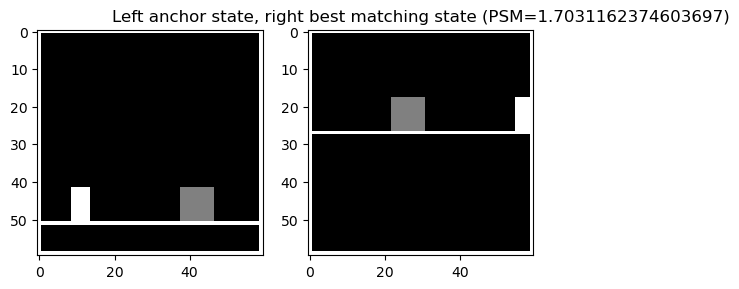

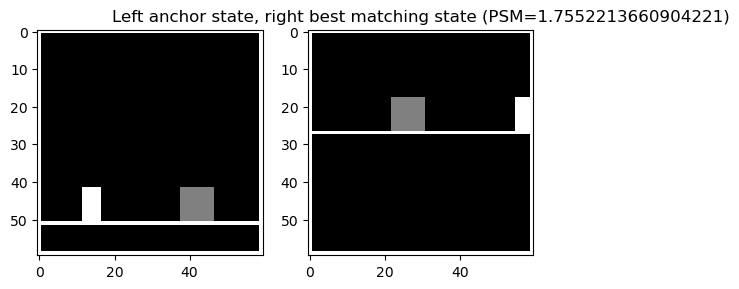

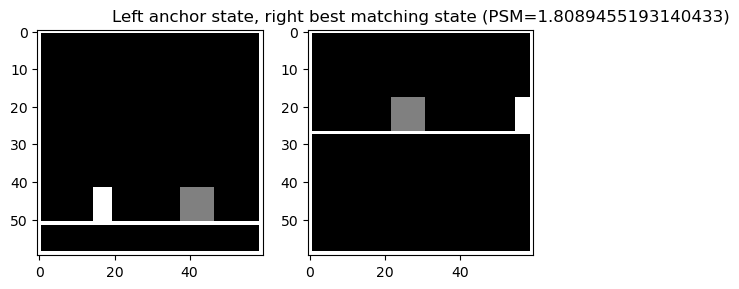

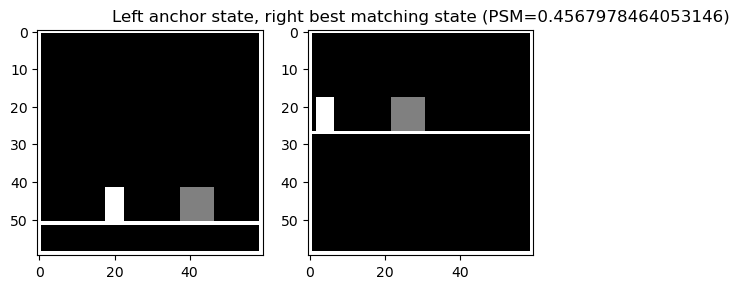

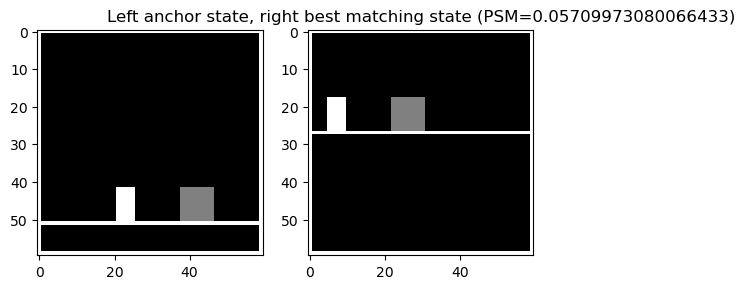

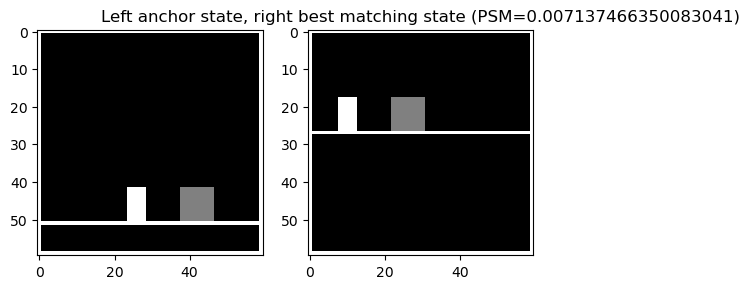

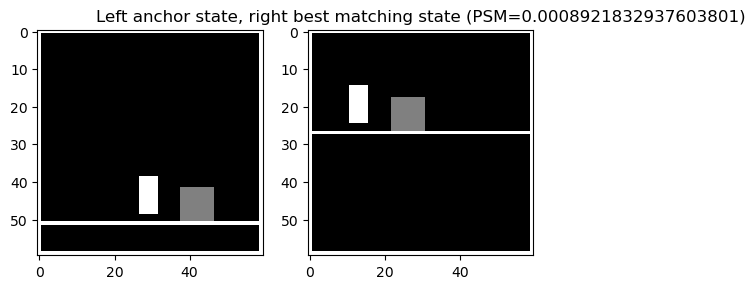

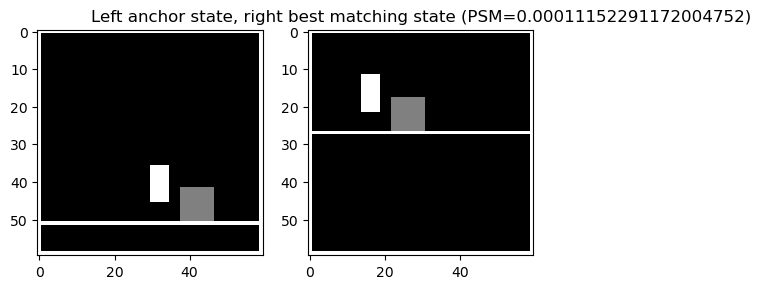

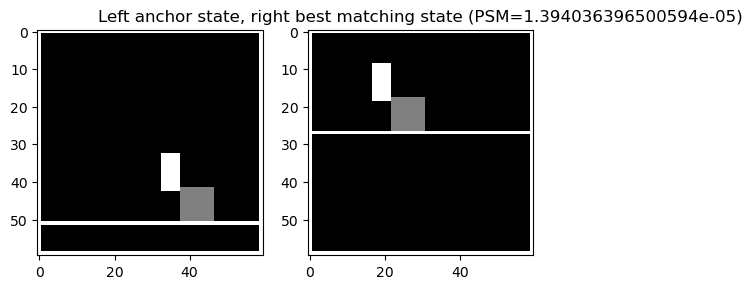

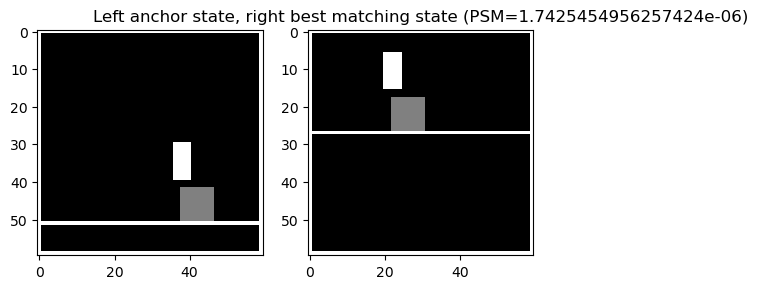

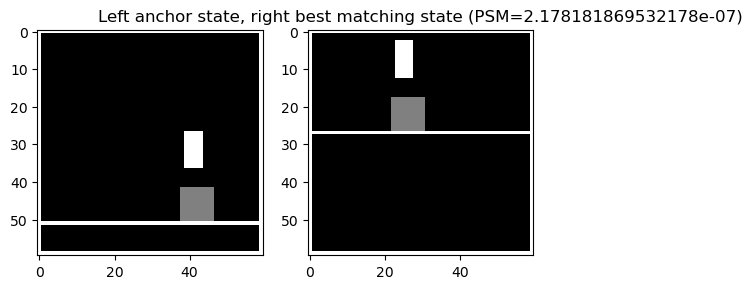

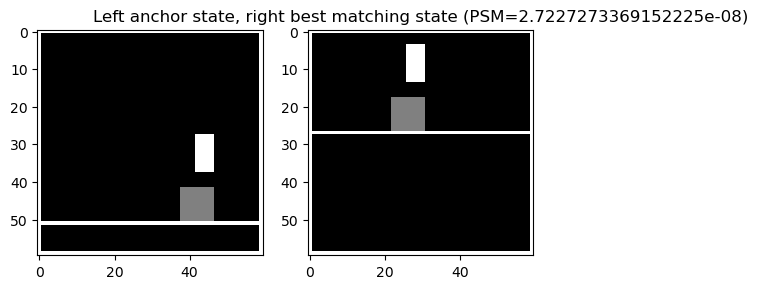

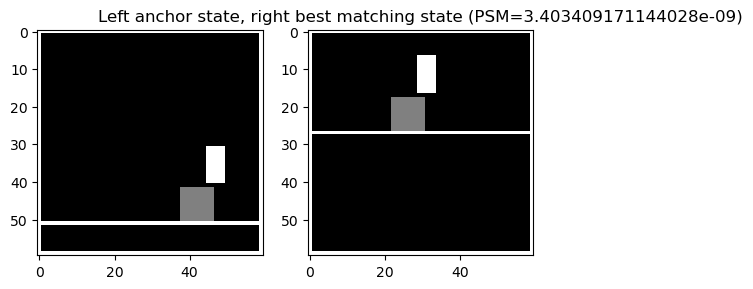

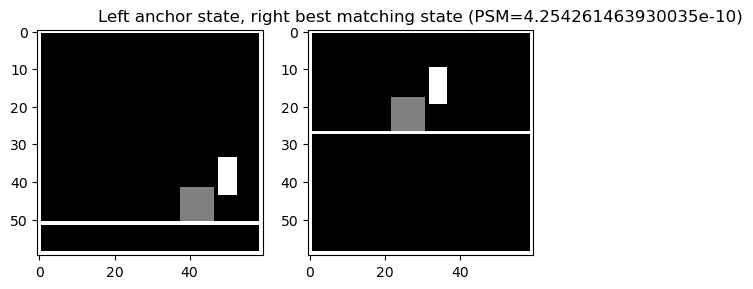

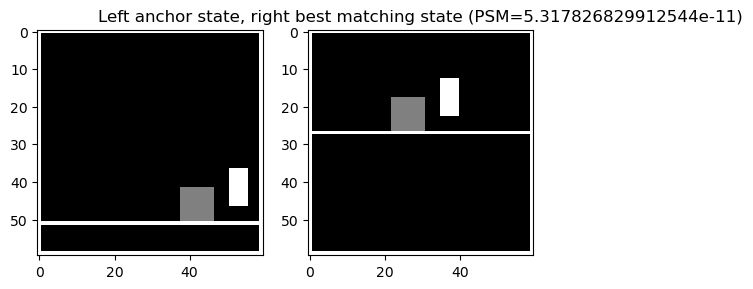

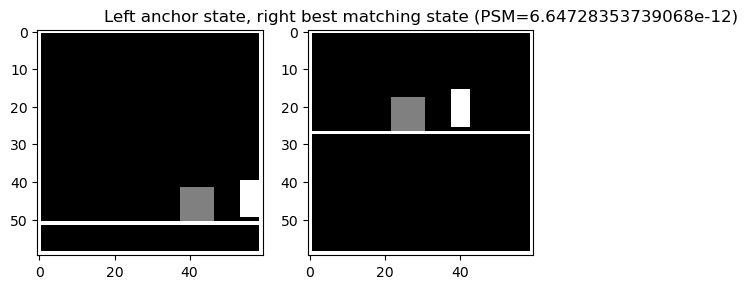

In [24]:
compare_idx = 20
psm = psm2_tot(X_action, Y_action)

for compare_idx in range(0, len(X_action)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    matching_idx = np.argmin(psm[compare_idx])
    if compare_idx % 3 == 0: compare_imgs(X.transitions[compare_idx].state, Y.transitions[matching_idx].state, f"Left anchor state, right best matching state (PSM={psm[compare_idx][matching_idx]})")


In [34]:
def psm3_tot(x_arr, y_arr, gamma_forward=0.99, gamma_backward=0.5):
    storage_fwrd = np.full(shape=(len(x_arr), len(y_arr)), fill_value=-1.0)
    storage_bwrd = np.full(shape=(len(x_arr), len(y_arr)), fill_value=-1.0)
    
    def psm2_dyn_forward(x_idx, y_idx):
        tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
        if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
            return tv
        else:
            next_x_idx = min(x_idx+1, len(x_arr)-1)
            next_y_idx = min(y_idx+1, len(y_arr)-1)

            next_psm = psm2_dyn_forward(next_x_idx, next_y_idx) if storage_fwrd[next_x_idx, next_y_idx] == -1 else storage_fwrd[next_x_idx, next_y_idx]
            return tv + gamma_forward * next_psm

    def psm2_dyn_backward(x_idx, y_idx):
        tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
        if x_idx == 0 and y_idx == 0:
            return tv
        else:
            past_x_idx = max(x_idx-1, 0)
            past_y_idx = max(y_idx-1, 0)

            past_psm = psm2_dyn_backward(past_x_idx, past_y_idx) if storage_bwrd[past_x_idx, past_y_idx] == -1 else storage_bwrd[past_x_idx, past_y_idx]
            return tv + gamma_backward * past_psm

    for i in range(len(x_arr)):
        for j in range(len(y_arr)):
            storage_fwrd[i,j] = psm2_dyn_forward(i,j) 
            storage_bwrd[i,j] = psm2_dyn_backward(i,j)
    return storage_fwrd + storage_bwrd
print(psm2_tot([1,0,0,0,0], [0,1,0,0,0]))
print(psm3_tot([1,0,0,0,0], [0,1,0,0,0]))

[[2.99     1.495    2.7475   3.37375  3.686875]
 [2.485    3.495    0.7475   1.37375  1.686875]
 [2.2325   3.2425   1.7475   0.37375  0.686875]
 [2.10625  3.11625  1.62125  0.87375  0.186875]
 [2.043125 3.053125 1.558125 0.810625 0.436875]]
[[2.99   0.5    2.25   2.625  2.8125]
 [1.49   2.5    0.25   0.625  0.8125]
 [1.24   2.25   0.75   0.125  0.3125]
 [1.115  2.125  0.625  0.375  0.0625]
 [1.0525 2.0625 0.5625 0.3125 0.1875]]


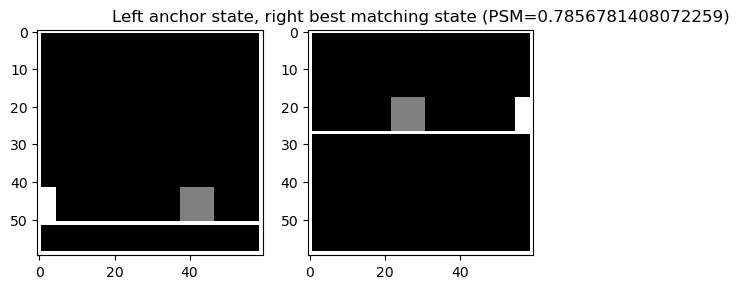

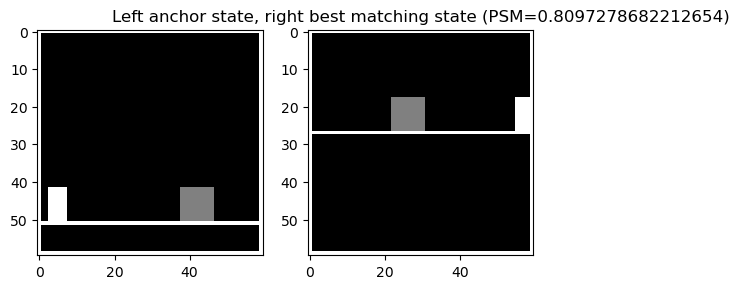

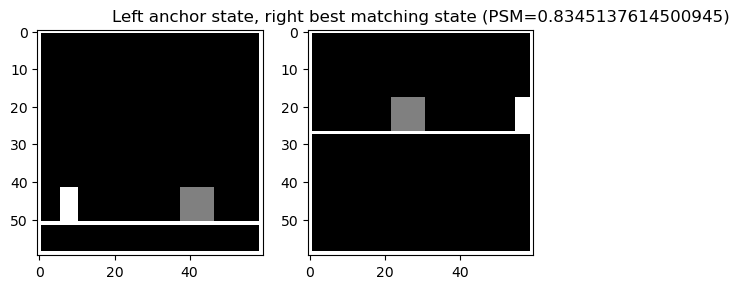

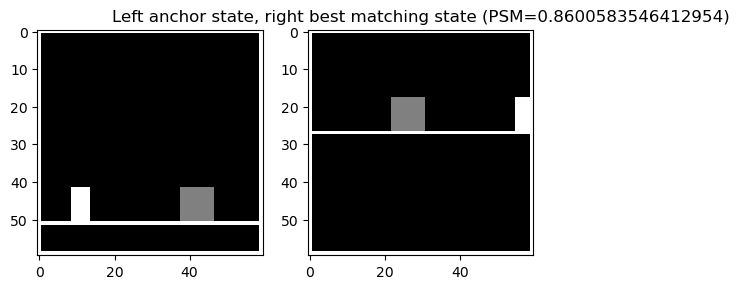

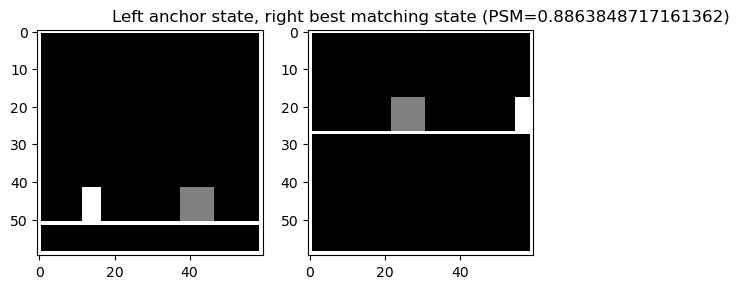

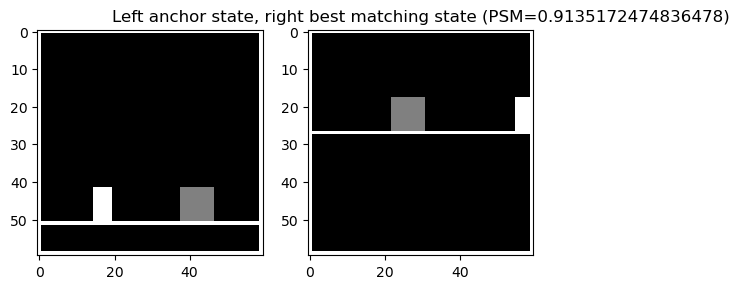

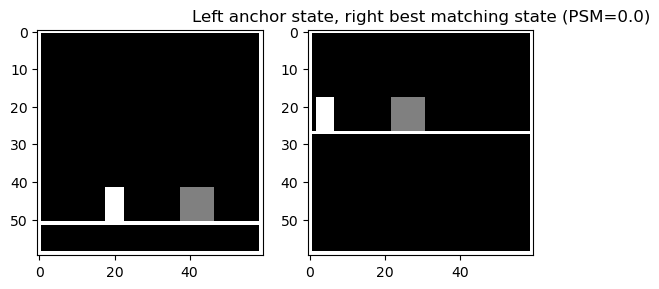

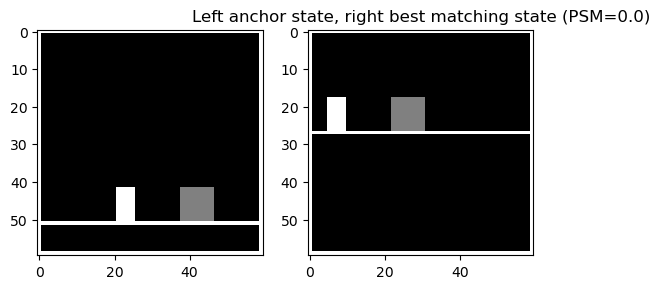

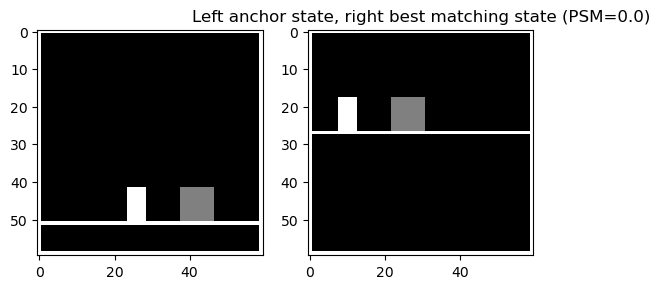

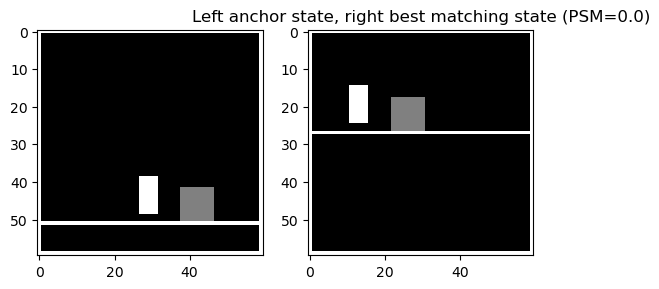

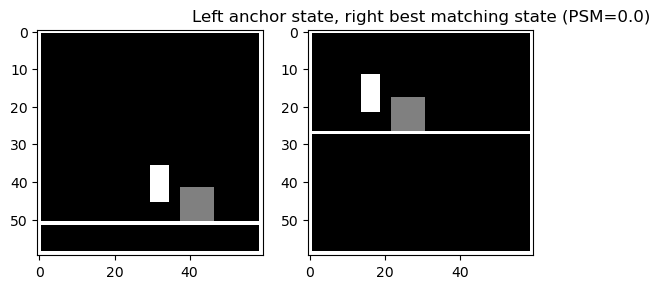

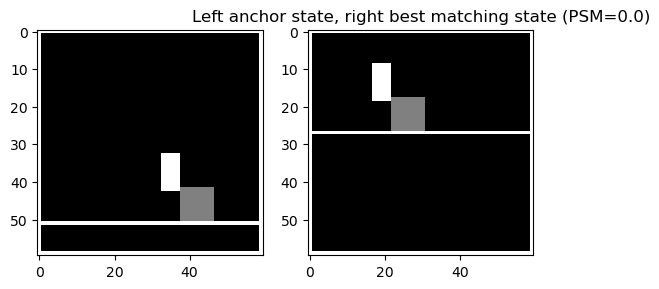

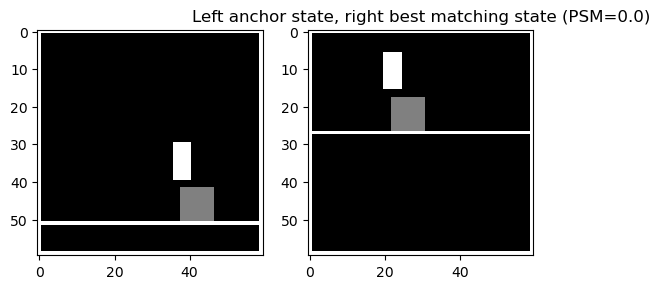

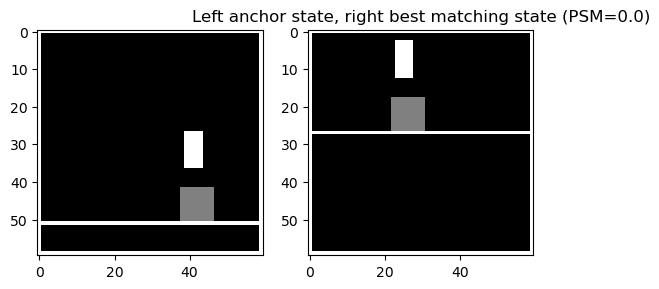

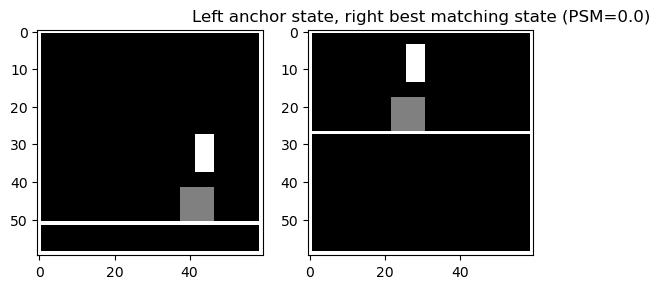

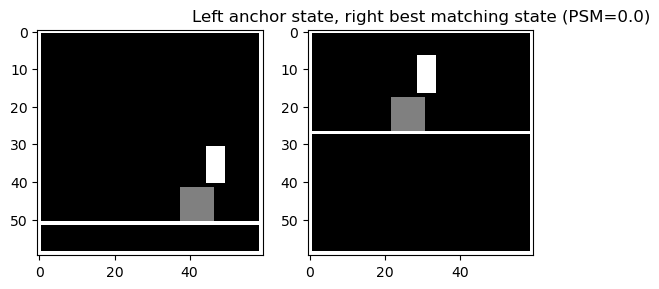

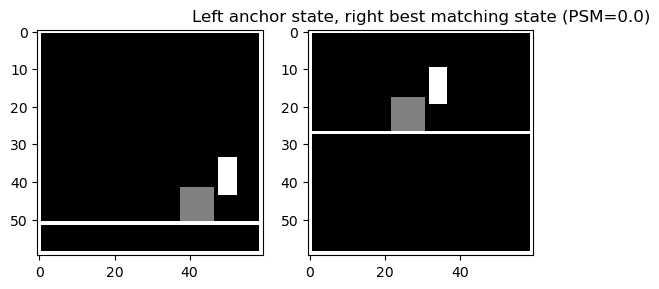

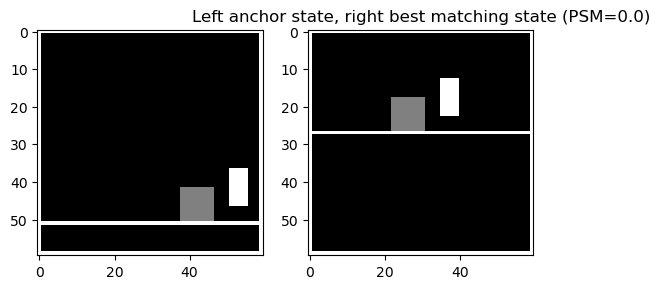

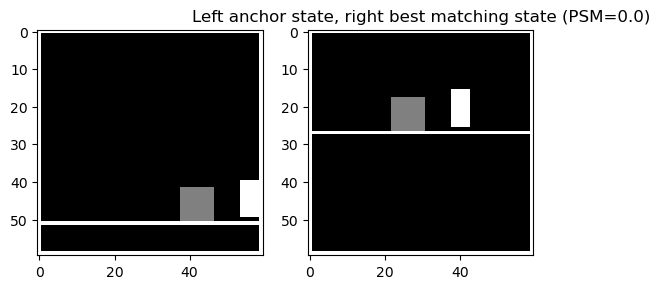

In [35]:
compare_idx = 20
psm = psm3_tot(X_action, Y_action)

for compare_idx in range(0, len(X_action)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    matching_idx = np.argmin(psm[compare_idx])
    if compare_idx % 3 == 0: compare_imgs(X.transitions[compare_idx].state, Y.transitions[matching_idx].state, f"Left anchor state, right best matching state (PSM={psm[compare_idx][matching_idx]})")
